In [77]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

## modelado
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [78]:
# Define a function to check for special characters
def has_special_characters(record):
    # Regular expression to match special characters
    return bool(re.search(r'[^a-zA-Z0-9\s]', record))


In [79]:
def check_possible_dummyable_variables(data, max_unique_values=10):
    """
    Check for possible dummyable variables in the DataFrame and return a DataFrame
    with column names, their number of unique values and ammount of NaN.

    Parameters:
    - data: pd.DataFrame
        The DataFrame to check.
    - max_unique_values: int
        The maximum number of unique values for a variable to be considered dummyable.

    Returns:
    - dummyable_vars_df: pd.DataFrame
        A DataFrame with two columns: 'Column' (column names), 'UniqueValues' (number of unique values) and 'TotalNan' (number of Nan).
    """
    dummyable_vars = []

    for col in data.columns:
        if ((data[col].dtype == 'object') | (data[col].dtype == 'category')) and len(data[col].unique()) < max_unique_values:
            nanValues = data[col].isna().sum()
            dummyable_vars.append({'Column': col, 'UniqueValues': len(data[col].unique()), 'TotalNan':  str(nanValues)})

    # Convert the list of dictionaries to a DataFrame
    dummyable_vars_df = pd.DataFrame(dummyable_vars)

    return dummyable_vars_df


In [80]:
def check_high_frequency_categories(data, min_unique_values=10):
    """
    Check for variables that have more than min_unique_values categories in the DataFrame and return a DataFrame
    with column names and their number of unique values.

    Parameters:
    - data: pd.DataFrame
        The DataFrame to check.
    - max_unique_values: int
        The maximum number of unique values for a variable to be considered dummyable.

    Returns:
    - dummyable_vars_df: pd.DataFrame
        A DataFrame with two columns: 'Column' (column names), 'UniqueValues' (number of unique values) and 'TotalNan' (number of Nan).
    """
    dummyable_vars = []

    for col in data.columns:
        if ((data[col].dtype == 'object') | (data[col].dtype == 'category')) and len(data[col].unique()) >= min_unique_values:
            nanValues = data[col].isna().sum()
            dummyable_vars.append({'Column': col, 'UniqueValues': len(data[col].unique()), 'TotalNan':  str(nanValues)})

    # Convert the list of dictionaries to a DataFrame
    dummyable_vars_df = pd.DataFrame(dummyable_vars)

    return dummyable_vars_df


# Inspección de variables
Cargar los documentos y revisar variables categóricas y numericas

In [81]:
df_train = pd.read_csv('training_values.csv', delimiter=',')
df_label = pd.read_csv('training_labels.csv', delimiter=',')
df_test = pd.read_csv('Test.csv', delimiter=',')

print(df_train.shape)
print(df_label.shape)
print('------')
print(df_test.shape)

(59400, 40)
(59400, 2)
------
(14850, 40)


In [82]:
# Todo:
# Combinar df_pump y df_test para aplicar las transformaciones en ambos dataframes - crear una columna para identificar los dataframes de origen
# Validar Id's
# Verificar tipologia de variables
# Valores fuera de rango
# Eliminar las variables que no aportan información
# Verificar si hay valores nulos

In [83]:
df_train['original_file'] = 'train'
df_test['original_file'] = 'test'

# Concatenate the train and test DataFrames
# to apply transformations on both dataframes
# and create a column to identify the source DataFrame

df_pump = pd.concat([df_train, df_test], axis=0)
df_pump.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 0 to 14849
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69743 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lga    

In [84]:
print(df_pump['id'].duplicated().value_counts())
print(df_label['id'].duplicated().value_counts())

id
False    74250
Name: count, dtype: int64
id
False    59400
Name: count, dtype: int64


In [85]:
print(df_label['id'].isin(df_pump['id']).value_counts())

id
True    59400
Name: count, dtype: int64


In [86]:
var_categoricas = df_pump.select_dtypes(include=['object','category']).columns
var_num = df_pump.select_dtypes(exclude=['object','category']).columns

In [87]:
df_pump.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,original_file
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train


In [88]:
# Analizar las variables de forma individual desde el reporte
pr = ProfileReport(df=df_pump)
pr.to_file('reporte.html')

Summarize dataset:  90%|████████▉ | 43/48 [00:01<00:00, 20.12it/s, Calculate auto correlation]      /opt/anaconda3/envs/Mineria/lib/python3.11/site-packages/ydata_profiling/model/correlations.py:87: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot reindex on an axis with duplicate labels')
  warnings.warn(
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 168.01it/s]


# Tipología de variables

In [89]:
# Clasifico las variables por conceptos: tipo date, personas, zona, pozo y costos - de acuerdo a alguna caracteristicas común
# Para analizar en caso de que se necesite hacer inferencia
tipo_date = ['date_recorded']
tipo_zona = ["wpt_name", "basin", "subvillage", "region", "lga", "ward", "gps_height", "longitude", "latitude", "region_code", "district_code"]
tipo_costos = ['payment','payment_type']
tipo_personas = ["funder", "installer", "public_meeting", "recorded_by", "scheme_management", "scheme_name", "management", "management_group"]
tipo_pozo = ["permit", "extraction_type", "extraction_type_group", "extraction_type_class", "water_quality", "quality_group", "quantity", "quantity_group", "source", "source_type", "source_class", "waterpoint_type", "waterpoint_type_group", "amount_tsh", "population", "construction_year"]



In [90]:
# En latitude, los valores muy pequeños, los transformo a cero
# Correcciones para trabajar con latitud/lomguitud antes de reemplazar con las columnas dummies y reemplazo con frecuencia
threshold = 1e-6
df_pump['latitude'] = df_pump['latitude'].apply(lambda x: 0 if abs(x) < threshold else x)

In [91]:
df_subvillage_nonzero = df_pump[((df_pump['longitude'] != 0) & (df_pump['latitude'] != 0))][tipo_zona]

subvillaje_med_location = df_subvillage_nonzero.groupby(['subvillage']).agg(
    {
        'longitude': 'median',
        'latitude': 'median'
    }
)

df_subvillage_error = df_pump[((df_pump['longitude'] == 0) | (df_pump['latitude'] == 0))][tipo_zona]


In [92]:
subvillaje_med_location.reset_index(inplace=True)
subvillaje_med_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20617 entries, 0 to 20616
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subvillage  20617 non-null  object 
 1   longitude   20617 non-null  float64
 2   latitude    20617 non-null  float64
dtypes: float64(2), object(1)
memory usage: 483.3+ KB


In [93]:
df_pump = df_pump.merge(subvillaje_med_location, on='subvillage', how='left', suffixes=('','_median'))


In [94]:
df_pump['latitude'] = df_pump.apply(lambda x: x['latitude_median'] if x['latitude'] == 0 else  x['latitude'] , axis=1)
df_pump['longitude'] = df_pump.apply(lambda x: x['longitude_median'] if x['longitude'] == 0 else  x['longitude'] , axis=1)

In [95]:
df_pump.drop(columns=['latitude_median', 'longitude_median'], inplace=True)

In [96]:
dummyable_cat = check_possible_dummyable_variables(df_pump, 15)
dummyable_cat.sort_values(by='UniqueValues', ascending=False)

,Column,UniqueValues,TotalNan
5,extraction_type_group,13,0
3,scheme_management,12,4847
7,management,12,0
15,source,10,0
0,basin,9,0
11,water_quality,8,0
9,payment,7,0
18,waterpoint_type,7,0
16,source_type,7,0
10,payment_type,7,0


In [97]:
#Analizar permit, public_meeting, scheme_management
# df_pump.recorded_by.value_counts(dropna=False)
#Eliminar recorded_by

#df_pump.permit.value_counts(dropna=False)
# reemplazar nan for unkown

# df_pump.public_meeting.value_counts(dropna=False, normalize=True)
# reemplazar nan for unkown

#df_pump.scheme_management.value_counts(dropna=False, normalize=True)
# reemplazar nan for unkown


In [98]:
# Gestionando los NaN
df_pump['permit'] = df_pump['permit'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['public_meeting'] = df_pump['public_meeting'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['scheme_management'] = df_pump['scheme_management'].apply(lambda x: 'Unknown' if pd.isna(x) else x)

In [99]:

# df_pump.extraction_type_group.value_counts(dropna=False, normalize=True)
# df_pump.scheme_management.value_counts(dropna=False, normalize=True)
# df_pump.management.value_counts(dropna=False, normalize=True)
df_pump.source.value_counts(dropna=False, normalize=True)


source
spring                  0.285737
shallow well            0.284714
machine dbh             0.186155
river                   0.161131
rainwater harvesting    0.038559
hand dtw                0.014923
lake                    0.012795
dam                     0.011313
other                   0.003515
unknown                 0.001158
Name: proportion, dtype: float64

In [100]:
# Agrupacion de valores raros
# Horizontal list
extraction_type_group_rare = ['india mark ii', 'afridev', 'rope pump', 'other handpump', 'wind-powered', 'other motorpump', 'india mark iii', 'swn 80', 'mono', 'other']
df_pump['extraction_type_group'] = np.where(df_pump['extraction_type_group'].isin(extraction_type_group_rare), 'Other minor extraction type', df_pump['extraction_type_group'])

scheme_management_rare = ['Water Board', 'WUA', 'Water authority', 'Parastatal', 'Company', 'Private operator', 'Other', 'SWC', 'Trust']
df_pump['scheme_management'] = np.where(df_pump['scheme_management'].isin(scheme_management_rare), 'Other minor scheme', df_pump['scheme_management'])

management_rare = ['private operator', 'parastatal', 'water authority', 'other', 'company', 'unknown', 'other - school', 'trust']
df_pump['management'] = np.where(df_pump['management'].isin(management_rare), 'Other minor Operator', df_pump['management'])

source_rare = ['rainwater harvesting', 'hand dtw', 'lake', 'dam', 'other', 'unknown']
df_pump['source'] = np.where(df_pump['source'].isin(source_rare), 'Other minor source', df_pump['source'])


In [101]:
# Eliminar recorded_by - No aporta informacion 
df_pump.drop(columns='recorded_by', inplace=True)

In [102]:
dummyable_cat = check_possible_dummyable_variables(df_pump, 15)
dummyable_cat.sort_values(by='UniqueValues', ascending=False)

,Column,UniqueValues,TotalNan
0,basin,9,0
10,water_quality,8,0
5,extraction_type_class,7,0
8,payment,7,0
9,payment_type,7,0
17,waterpoint_type,7,0
15,source_type,7,0
11,quality_group,6,0
18,waterpoint_type_group,6,0
14,source,5,0


In [103]:
tipo_personas = ["funder", "installer", "public_meeting", "scheme_management", "scheme_name", "management", "management_group"]

In [104]:
df_pump.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,original_file
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,Other minor source,rainwater harvesting,surface,communal standpipe,communal standpipe,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,Other minor source,dam,surface,communal standpipe multiple,communal standpipe,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,Other minor source,rainwater harvesting,surface,communal standpipe,communal standpipe,train


In [105]:
# Procesar categorías que tienen mas de 15 únicos valores

In [106]:
high_freq_cat = check_high_frequency_categories(df_pump, 15)
high_freq_cat.sort_values(by='UniqueValues', ascending=False)


,Column,UniqueValues,TotalNan
3,wpt_name,45684,2
4,subvillage,21426,470
8,scheme_name,2868,36052
2,installer,2411,4532
1,funder,2140,4507
7,ward,2098,0
0,date_recorded,369,0
6,lga,125,0
5,region,21,0
9,extraction_type,18,0


In [107]:
# Gestionar los NaN de las variables categoricas que tienen alta frecuencia de categorias

# df_pump.wpt_name.value_counts(dropna=False, normalize=True)
# 2 faltantes, reemplazar por unknown

# df_pump.subvillage.value_counts(dropna=False, normalize=True)
# Menor al 1%, reemplazar por unknown

# df_pump.scheme_name.value_counts(dropna=False, normalize=True)
# scheme_name y scheme management tienen la misma descripcion, ambas columnas representan la misma informacion
# Se puede utilizar la informacion de scheme management para llenar lo faltante de scheme_name (no óptima) o eliminar la columna,
# porque ya tenemos al informacion mejor organizada en la otra columna y hay gran cantidad de faltantes ~50% faltantes
# Se elimna la columna


# df_pump.installer.value_counts(dropna=False, normalize=True)
# Reemplazar faltantes con Unknown ~6%

# df_pump.funder.value_counts(dropna=False, normalize=True)
# Reemplazar faltantes con Unknown ~6%

In [108]:
df_pump['wpt_name'] = df_pump['wpt_name'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['subvillage'] = df_pump['subvillage'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['installer'] = df_pump['installer'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_pump['funder'] = df_pump['funder'].apply(lambda x: 'Unknown' if pd.isna(x) else x)

df_pump.drop(columns='scheme_name', inplace=True)

In [109]:
high_freq_cat = check_high_frequency_categories(df_pump, 15)
high_freq_cat.sort_values(by='UniqueValues', ascending=False)


,Column,UniqueValues,TotalNan
3,wpt_name,45683,0
4,subvillage,21426,0
2,installer,2410,0
1,funder,2139,0
7,ward,2098,0
0,date_recorded,369,0
6,lga,125,0
5,region,21,0
8,extraction_type,18,0


In [110]:
tipo_personas = ["funder", "installer", "public_meeting", "scheme_management", "management", "management_group"]
df_pump[tipo_personas]

,funder,installer,public_meeting,scheme_management,management,management_group
0,Roman,Roman,True,VWC,vwc,user-group
1,Grumeti,GRUMETI,Unknown,Other minor scheme,wug,user-group
2,Lottery Club,World vision,True,VWC,vwc,user-group
3,Unicef,UNICEF,True,VWC,vwc,user-group
4,Action In A,Artisan,True,Unknown,Other minor Operator,other
...,...,...,...,...,...,...
74245,Danida,Da,True,VWC,vwc,user-group
74246,Hiap,HIAP,True,VWC,vwc,user-group
74247,Unknown,Unknown,True,VWC,vwc,user-group
74248,Germany,DWE,True,VWC,vwc,user-group


In [111]:
# Crear Dummy columns para las variables categoricas que tienen poca frecuencia de categorias
# Reemplazar por la frecuencia a las variables categoricas que tienen alta frecuencia de categorias

In [112]:
# No quitar el elemento que ayuda a identificar si es train o test
dummyable_cat_rev = dummyable_cat.drop(index=19)

In [113]:
## Transformamos las variables a dummies

for k in dummyable_cat_rev['Column']:
    dummies = pd.get_dummies(df_pump[k], prefix=k)
    df_pump = pd.concat([df_pump, dummies], axis=1)

In [114]:
df_pump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Columns: 145 entries, id to waterpoint_type_group_other
dtypes: bool(106), float64(3), int64(7), object(29)
memory usage: 29.6+ MB


In [115]:
high_freq_cat_rev =  high_freq_cat.drop(index=0)

In [116]:
high_freq_cat_rev

,Column,UniqueValues,TotalNan
1,funder,2139,0
2,installer,2410,0
3,wpt_name,45683,0
4,subvillage,21426,0
5,region,21,0
6,lga,125,0
7,ward,2098,0
8,extraction_type,18,0


In [117]:
# Transformamos las otras variables categoricas reemplazando por frecuencia
for i in high_freq_cat_rev['Column']:
    df_pump[i + '_freq'] = df_pump[i].map(df_pump[i].value_counts())
    df_pump[i + '_freq'].astype(int)

In [118]:
df_pump.to_csv('../revision.csv')

In [119]:
# Revisar los valores numericos
print(var_num)

# df_pump['amount_tsh'].value_counts(normalize=True)
# Mantener - puede ser del tipo que recoge agua de lluvia

# df_pump['gps_height'].value_counts(normalize=True, dropna=False)
# Mantener

# df_pump['longitude'].value_counts(normalize=True, dropna=False)
# Remover registros malos ~2%

# df_pump['latitude'].value_counts(normalize=True, dropna=False)
# Remover registros malos ~2%

# df_pump['num_private'].value_counts(normalize=True, dropna=False)
# Eliminar columna - No hay referencias de que es y tien el 98% de nan

# df_pump['region_code'].value_counts(normalize=True, dropna=False)
# Correcto - no hacer nada


# df_pump['district_code'].value_counts(normalize=False, dropna=False)
# Eliminar registros equivocados - 27 registros

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')


In [120]:
df_pump[df_pump['population'] == 0][tipo_zona].head()

,wpt_name,basin,subvillage,region,lga,ward,gps_height,longitude,latitude,region_code,district_code
4,Shuleni,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,0,31.130847,-1.825359,18,1
6,Kwa Ngomho,Internal,Ishinabulandi,Shinyanga,Shinyanga Rural,Samuye,0,33.362410,-3.766365,17,3
7,Tushirikiane,Lake Tanganyika,Nyawishi Center,Shinyanga,Kahama,Chambo,0,32.620617,-4.226198,17,3
8,Kwa Ramadhan Musa,Lake Tanganyika,Imalauduki,Tabora,Tabora Urban,Itetemia,0,32.711100,-5.146712,14,6
9,Kwapeto,Lake Victoria,Mkonomre,Kagera,Karagwe,Kaisho,0,30.626991,-1.257051,18,1


In [121]:
df_pump_filtered = df_pump[df_pump['population'] > 0]
aggregated_data = df_pump_filtered.groupby(['subvillage']).agg({'population': 'max'})
aggregated_data = aggregated_data[aggregated_data['population'] > 0]

In [122]:
df_pump['population'].value_counts(normalize=True, dropna=False)
# Se pudo extraer mucha informacion de la columna Subvillage, pero hay un 26% que no tiene datos
# Imputacion por mediana podria ser una alternativa

population
0       0.361401
1       0.118276
200     0.031919
150     0.031354
250     0.028108
          ...   
3236    0.000013
1840    0.000013
1265    0.000013
2652    0.000013
2960    0.000013
Name: proportion, Length: 1128, dtype: float64

In [123]:
aggregated_data = df_pump.groupby(['subvillage']).agg({'population': 'max'})
aggregated_data = aggregated_data[aggregated_data['population'] > 0]
aggregated_data.reset_index(inplace=True)
aggregated_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13319 entries, 0 to 13318
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subvillage  13319 non-null  object
 1   population  13319 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 208.2+ KB


In [124]:
df_pump = df_pump.merge(aggregated_data, how="left", on='subvillage', suffixes=('', '_count'))

In [125]:
df_pump[(df_pump['population'] == 0) & (df_pump['population_count'] !=0)][tipo_pozo]

,permit,extraction_type,extraction_type_group,extraction_type_class,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amount_tsh,population,construction_year
4,True,gravity,gravity,gravity,soft,good,seasonal,seasonal,Other minor source,rainwater harvesting,surface,communal standpipe,communal standpipe,0.0,0,0
6,True,swn 80,Other minor extraction type,handpump,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,0.0,0,0
7,True,nira/tanira,nira/tanira,handpump,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,0.0,0,0
8,True,india mark ii,Other minor extraction type,handpump,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,0.0,0,0
9,True,nira/tanira,nira/tanira,handpump,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74235,True,nira/tanira,nira/tanira,handpump,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,0.0,0,0
74238,False,gravity,gravity,gravity,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,3000.0,0,1986
74240,True,gravity,gravity,gravity,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,0.0,0,2009
74241,False,swn 80,Other minor extraction type,handpump,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,0.0,0,0


In [126]:
df_pump['population'] = df_pump.apply(lambda x: x['population_count'] if x['population'] == 0 else x['population'], axis=1)

In [127]:
df_pump.drop(columns='population_count', inplace=True)

In [128]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
df_pump['population']  = imputer.fit_transform(df_pump[["population"]])


In [129]:
# df_pump['population'].value_counts(normalize=True, dropna=False)
# Se pudo extraer mucha informacion de la columna Subvillage, pero hay un 26% que no tiene datos
# Imputacion por mediana podria ser una alternativa

df_pump['construction_year'].value_counts(normalize=True, dropna=False)


construction_year
0       0.349751
2010    0.044633
2008    0.043677
2009    0.043044
2000    0.034721
2007    0.026397
2006    0.025481
2011    0.021428
2003    0.021266
2004    0.019084
2012    0.018141
2002    0.018088
1995    0.017279
2005    0.017172
1978    0.017064
1999    0.016458
1998    0.016027
1985    0.015852
1990    0.015838
1996    0.013737
1980    0.013535
1984    0.013064
1994    0.012660
1982    0.012471
1972    0.012013
1997    0.011057
1974    0.010963
1992    0.010869
1993    0.010034
2001    0.009158
1988    0.008848
1983    0.008000
1975    0.007556
1986    0.007448
1976    0.007071
1970    0.006640
1991    0.005481
1989    0.005333
1987    0.004983
1981    0.003919
1977    0.003327
1979    0.003300
1973    0.003057
2013    0.002815
1971    0.002384
1960    0.001670
1963    0.001441
1967    0.001428
1968    0.001253
1969    0.001037
1964    0.000646
1962    0.000485
1961    0.000377
1965    0.000283
1966    0.000256
Name: proportion, dtype: float64

In [130]:
df_pump['construction_year'] = df_pump['construction_year'].apply(lambda x: np.nan if x == 0 else x)

In [131]:
df_pump[df_pump['construction_year']== 1965][['date_recorded', 'construction_year']].head()

,date_recorded,construction_year
5814,2011-03-14,1965.0
9753,2013-02-15,1965.0
17332,2013-03-13,1965.0
21733,2013-02-15,1965.0
27390,2013-02-15,1965.0


In [132]:
df_pump[(df_pump['ward'] == 'Gode Gode') & (df_pump['district_code'] != 0)][tipo_zona].head()

,wpt_name,basin,subvillage,region,lga,ward,gps_height,longitude,latitude,region_code,district_code


<Axes: xlabel='construction_year', ylabel='Count'>

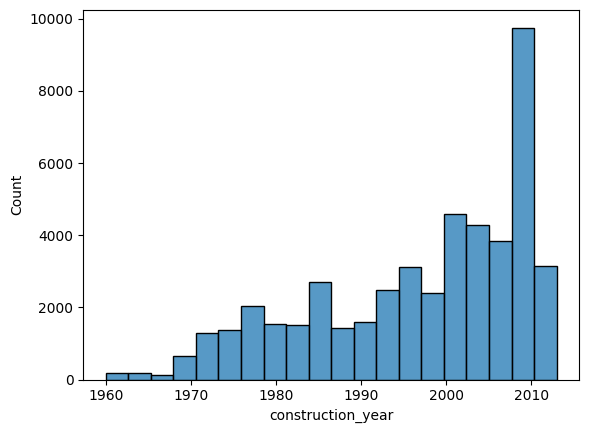

In [133]:
sns.histplot(df_pump['construction_year'].dropna(), bins=20, kde=False)

In [134]:
# Imputamos por el mas frecuente - moda
imputer = SimpleImputer(strategy='most_frequent')
df_pump['construction_year'] = imputer.fit_transform(df_pump[['construction_year']])

In [135]:
# df_pump['longitude'].value_counts(normalize=True, dropna=False)
# Remover registros malos ~2%


# df_pump['latitude'].value_counts(normalize=True, dropna=False)
# Remover registros malos ~2%

# df_pump['num_private'].value_counts(normalize=True, dropna=False)
# Eliminar columna - No hay referencias de que es y tien el 98% de nan

In [136]:
df_pump['longitude'].fillna(0, inplace=True)
df_pump['latitude'].fillna(0, inplace=True)

df_pump = df_pump[df_pump['longitude'] != 0]
df_pump = df_pump[df_pump['latitude'] != 0]
df_pump.drop(columns='num_private', inplace=True)

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_46149/2494745831.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pump['longitude'].fillna(0, inplace=True)
/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_46149/2494745831.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [137]:
df_pump['longitude'].value_counts(dropna=False)

longitude
36.072187    91
34.807859    25
31.118608    21
36.885545    20
36.921743    19
             ..
38.962623     1
35.388704     1
36.956682     1
33.231717     1
34.765054     1
Name: count, Length: 71976, dtype: int64

Trabajar con la variable tipo Date - que se puede extraer rapidamente valores numericos

In [138]:
df_pump['date_recorded'] = pd.to_datetime(df_pump['date_recorded'])
df_pump['year'] = df_pump['date_recorded'].dt.year
df_pump['month'] = df_pump['date_recorded'].dt.month
df_pump['day'] = df_pump['date_recorded'].dt.day
df_pump['day_of_week'] = df_pump['date_recorded'].dt.dayofweek
df_pump['day_of_week'].value_counts(normalize=True)


day_of_week
2    0.157414
3    0.149602
4    0.147968
1    0.142408
5    0.139209
0    0.139154
6    0.124245
Name: proportion, dtype: float64

In [139]:
df_pump['duracion']=(pd.to_datetime('2013-12-31') - df_pump['date_recorded']).dt.days

In [140]:
## Aplicar al final
## No borrar
# Eliminar la columna original de donde se hizo los dummies
for k in dummyable_cat_rev['Column']:
    df_pump.drop(columns=k, inplace=True)

In [141]:
# Eliminamos las categorias originales, despues que fueron transformadas
for k in high_freq_cat_rev['Column']:
    df_pump.drop(columns=k, inplace=True)

In [142]:
df_pump.drop(columns='date_recorded', inplace=True)

In [143]:
df_pump.to_csv('../data_depurada_train_test.csv')

In [144]:
data_train = df_pump[df_pump['original_file'] == 'train']
data_test = df_pump[df_pump['original_file'] == 'test']

data_train.drop(columns='original_file', inplace=True)
data_test.drop(columns='original_file', inplace=True)

data_train.to_csv('../data_train.csv')
data_test.to_csv('../data_test.csv')

/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_46149/1780475764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.drop(columns='original_file', inplace=True)
/var/folders/cl/09x12tsj45s7jvjtkzttqgxh0000gn/T/ipykernel_46149/1780475764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.drop(columns='original_file', inplace=True)


In [ ]:
# Agregar la columna con las categorias respuesta
# Entrenar los modelos